In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [51]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    # This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25)
        )
       # self.avgpool = nn.AvgPool2d(5)
        self.gap = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0),
        )
        self.fc1 = nn.Linear(90, 10)

    def forward(self, x):
        x = self.conv1(x)
        # x = F.relu(F.max_pool2d(x, 2))
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


In [52]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
            Conv2d-4           [-1, 16, 28, 28]           2,320
              ReLU-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
         MaxPool2d-7           [-1, 16, 14, 14]               0
           Dropout-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,320
             ReLU-10           [-1, 16, 14, 14]               0
      BatchNorm2d-11           [-1, 16, 14, 14]              32
           Conv2d-12           [-1, 16, 14, 14]           2,320
             ReLU-13           [-1, 16, 14, 14]               0
      BatchNorm2d-14           [-1, 16,

In [53]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [54]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [55]:
batch_size = 256

kwargs = {'batch_size': batch_size, 'shuffle': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

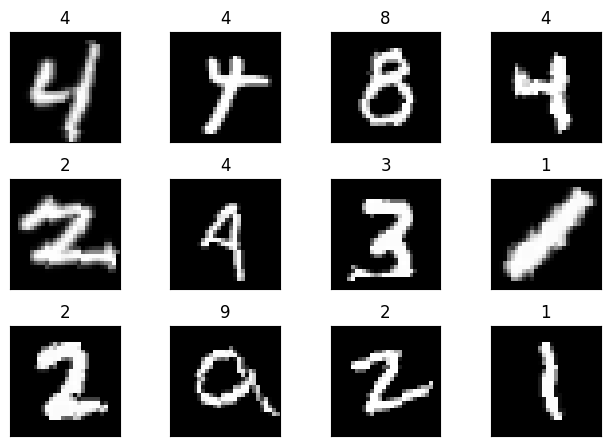

In [56]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [57]:
from tqdm import tqdm

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {"images": [], "ground_truths": [], "predicted_vals": []}


def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(
            desc=f"Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}"
        )

    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))
    return train_acc, train_losses


def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(
                output, target, reduction="sum"
            ).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)
    test_acc.append(100.0 * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    return test_acc, test_losses

In [58]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_acc, train_losses = train(model, device, train_loader, optimizer, criterion)
  test_acc, test_losses = test(model, device, test_loader, criterion)
  scheduler.step()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=0.2024 Batch_id=234 Accuracy=91.63: 100%|██████████| 235/235 [01:49<00:00,  2.15it/s]


Test set: Average loss: 0.0410, Accuracy: 9870/10000 (98.70%)

Epoch 2


Train: Loss=0.0169 Batch_id=234 Accuracy=97.19: 100%|██████████| 235/235 [01:40<00:00,  2.34it/s]


Test set: Average loss: 0.0366, Accuracy: 9884/10000 (98.84%)

Epoch 3


Train: Loss=0.0351 Batch_id=234 Accuracy=97.71: 100%|██████████| 235/235 [01:41<00:00,  2.32it/s]


Test set: Average loss: 0.0289, Accuracy: 9911/10000 (99.11%)

Epoch 4


Train: Loss=0.0595 Batch_id=234 Accuracy=97.86: 100%|██████████| 235/235 [01:40<00:00,  2.34it/s]


Test set: Average loss: 0.0250, Accuracy: 9918/10000 (99.18%)

Epoch 5


Train: Loss=0.0083 Batch_id=234 Accuracy=98.13: 100%|██████████| 235/235 [01:41<00:00,  2.32it/s]


Test set: Average loss: 0.0224, Accuracy: 9926/10000 (99.26%)

Epoch 6


Train: Loss=0.0628 Batch_id=234 Accuracy=98.17: 100%|██████████| 235/235 [01:42<00:00,  2.30it/s]


Test set: Average loss: 0.0218, Accuracy: 9922/10000 (99.22%)

Epoch 7


Train: Loss=0.1075 Batch_id=234 Accuracy=98.22: 100%|██████████| 235/235 [01:41<00:00,  2.31it/s]


Test set: Average loss: 0.0227, Accuracy: 9921/10000 (99.21%)

Epoch 8


Train: Loss=0.0866 Batch_id=234 Accuracy=98.36: 100%|██████████| 235/235 [01:41<00:00,  2.32it/s]


Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)

Epoch 9


Train: Loss=0.0679 Batch_id=234 Accuracy=98.42: 100%|██████████| 235/235 [01:38<00:00,  2.38it/s]


Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)

Epoch 10


Train: Loss=0.0456 Batch_id=234 Accuracy=98.58: 100%|██████████| 235/235 [01:39<00:00,  2.36it/s]


Test set: Average loss: 0.0176, Accuracy: 9945/10000 (99.45%)

Epoch 11


Train: Loss=0.0389 Batch_id=234 Accuracy=98.77: 100%|██████████| 235/235 [01:41<00:00,  2.31it/s]


Test set: Average loss: 0.0159, Accuracy: 9940/10000 (99.40%)

Epoch 12


Train: Loss=0.0266 Batch_id=234 Accuracy=98.80: 100%|██████████| 235/235 [01:39<00:00,  2.35it/s]


Test set: Average loss: 0.0153, Accuracy: 9948/10000 (99.48%)

Epoch 13


Train: Loss=0.0648 Batch_id=234 Accuracy=98.89: 100%|██████████| 235/235 [01:41<00:00,  2.32it/s]


Test set: Average loss: 0.0149, Accuracy: 9945/10000 (99.45%)

Epoch 14


Train: Loss=0.0375 Batch_id=234 Accuracy=98.86: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Test set: Average loss: 0.0152, Accuracy: 9945/10000 (99.45%)

Epoch 15


Train: Loss=0.0078 Batch_id=234 Accuracy=98.92: 100%|██████████| 235/235 [01:42<00:00,  2.30it/s]


Test set: Average loss: 0.0144, Accuracy: 9949/10000 (99.49%)

Epoch 16


Train: Loss=0.0949 Batch_id=234 Accuracy=98.90: 100%|██████████| 235/235 [01:41<00:00,  2.32it/s]


Test set: Average loss: 0.0147, Accuracy: 9945/10000 (99.45%)

Epoch 17


Train: Loss=0.0263 Batch_id=234 Accuracy=98.95: 100%|██████████| 235/235 [01:41<00:00,  2.32it/s]


Test set: Average loss: 0.0143, Accuracy: 9949/10000 (99.49%)

Epoch 18


Train: Loss=0.0149 Batch_id=234 Accuracy=98.94: 100%|██████████| 235/235 [01:40<00:00,  2.33it/s]


Test set: Average loss: 0.0145, Accuracy: 9950/10000 (99.50%)

Epoch 19


Train: Loss=0.0149 Batch_id=234 Accuracy=98.93: 100%|██████████| 235/235 [01:41<00:00,  2.33it/s]


Test set: Average loss: 0.0145, Accuracy: 9950/10000 (99.50%)

Epoch 20


Train: Loss=0.1101 Batch_id=234 Accuracy=98.96: 100%|██████████| 235/235 [01:39<00:00,  2.36it/s]


Test set: Average loss: 0.0144, Accuracy: 9951/10000 (99.51%)

